# Neural Style Transfer

#Generate a new image having the content of a given image and the style/texture of another image.
#Using pre-trained object recog model such as VGG

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10,10)
mpl.rcParams['axes.grid'] = False
import numpy as np
import time
import tensorflow as tf
import tensorflow.contrib.eager as tfe
from tensorflow.python.keras.preprocessing import image as kp_image
from tensorflow.python.keras import models, layers, losses
from tensorflow.python.keras import backend as K
from PIL import Image
import functools

C:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
#Enable eager execution
tf.enable_eager_execution()
#Set up global paths
style_path = r"C:\Users\Satashree\Desktop\ML-exercise\starry_night.jpg"
content_path = r"C:\Users\Satashree\Desktop\ML-exercise\tubingen.jpg"

In [3]:
#Visualize the input
def load_img(img_path):
    max_dim = 512
    img = Image.open(img_path)
    long = max(img.size)
    scale = max_dim/long
    img = img.resize((round(img.size[0]*scale), round(img.size[1]*scale)), Image.ANTIALIAS)
    img = kp_image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    return img

In [4]:
def show_img(img, title=None):
    out = np.squeeze(img, axis=0)
    out = out.astype('uint8')
    plt.imshow(out)
    if title is not None:
        plt.title(title)
    plt.imshow(out)

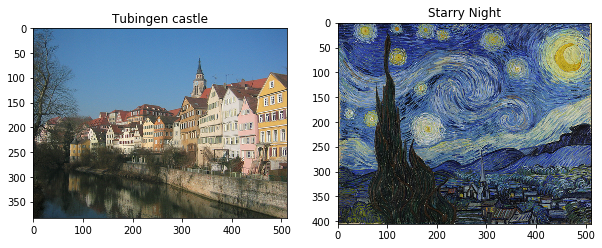

In [5]:
#show images
content = load_img(content_path)
style = load_img(style_path)

plt.figure(figsize = (10,10))
plt.subplot(1,2,1)
show_img(content, "Tubingen castle")
plt.subplot(1,2,2)
show_img(style, "Starry Night")


Load and Process the data
Normalize image by mean = [103.939, 116.779, 123.68] and with channels BGR

In [6]:
def load_and_process_img(img_path):
    img = load_img(img_path)
    img = tf.keras.applications.vgg19.preprocess_input(img)
    return img

In [7]:
def deprocess_img(processed_img):
  x = processed_img.copy()
  if len(x.shape) == 4:
    x = np.squeeze(x, 0)
  assert len(x.shape) == 3, ("Input to deprocess image must be an image of "
                             "dimension [1, height, width, channel] or [height, width, channel]")
  if len(x.shape) != 3:
    raise ValueError("Invalid input to deprocessing image")
  
  # perform the inverse of the preprocessiing step
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  x = x[:, :, ::-1]

  x = np.clip(x, 0, 255).astype('uint8')
  return x

Following intermediate layers of VGG19 will be used for the new model

In [8]:
content_layers = ['block5_conv2']
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1'
               ]
num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

BUILD THE MODEL

In [9]:
def get_model():
    """
    Load the pre_trained VGG model and access the intermediate layers.
    """
    vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights="imagenet")
    vgg.trainable = False
    #Get the output layers corresponding to content and style layers.
    style_outputs = [vgg.get_layer(name).output for name in style_layers]
    content_outputs = [vgg.get_layer(name).output for name in content_layers]
    model_outputs = style_outputs + content_outputs
    #Model
    return models.Model(vgg.input, model_outputs)

In [10]:
# get content loss, LContent
def get_content_loss(base_content, target):
    return tf.reduce_mean(tf.square(base_content - target))

In [11]:
# Get style loss, LStyle
def get_gram_matrix(input_tensor):
    channels = int(input_tensor.shape[-1])
    a = tf.reshape(input_tensor, [-1,channels])
    n = tf.shape(a)[0]
    gram = tf.matmul(a,a,transpose_a = True)
    return gram/tf.cast(n, tf.float32)


In [12]:
def get_style_loss(base_style, gram_target):
    h, w, c = base_style.get_shape().as_list()
    gram_style = get_gram_matrix(base_style)
    return tf.reduce_mean(tf.square(gram_style - gram_target)) # / (4*(channels**2*)*((h*w)**2))

In [13]:
def get_feature_representation(model, content_path, style_path):
    content_img = load_and_process_img(content_path)
    style_img = load_and_process_img(style_path)
    content_outputs = model(content_img)
    style_outputs = model(style_img)
    
    # get the features
    style_features = [style_layer[0] for style_layer in style_outputs[:num_style_layers]]
    content_features = [content_layer[0] for content_layer in content_outputs[num_style_layers:]]
    return style_features, content_features

Computing the loss, using GradientTape

In [14]:
def compute_loss(model, loss_weights, init_img, gram_style_features, content_features):
    """
    Arguments : 
    model : The model that gives access to intermediate layers
    loss_weights : (style_weight, content_weight, total_variation_weight), i.e, the contribution to each loss
    init_img : the image that is updated
    gram_style_features : gram matrices computed for the style layers of interest
    content_features : ouputs computed for the content layers of interest
    
    Return:
    total loss, content loss, style loss, variational_loss
    """
    style_weight, content_weight = loss_weights
    model_outputs = model(init_img)
    style_output_features = model_outputs[:num_style_layers]
    content_output_features = model_outputs[num_style_layers:]
    
    style_score = 0
    content_score = 0
    
    weight_per_style_layer = 1.0/float(num_style_layers)
    for target_style, comb_style in zip(gram_style_features, style_output_features):
        style_score += weight_per_style_layer*get_style_loss(comb_style[0], target_style)
        
    weight_per_content_layer = 1.0/float(num_content_layers)
    for target_content, comb_content in zip(content_features, content_output_features):
        content_score += weight_per_content_layer*get_content_loss(comb_content[0], target_content)
        
    style_score *= style_weight
    content_score *= content_weight
    
    #total loss
    loss = style_score + content_score
    return loss, style_score, content_score

In [15]:
def compute_grads(cfg):
    with tf.GradientTape() as tape:
        all_loss = compute_loss(**cfg)
    total_loss = all_loss[0]
    return tape.gradient(total_loss, cfg["init_img"]), all_loss

In [16]:
import IPython.display
def run_style_transfer(content_path,style_path,num_iters=1000,content_weight=1e3,style_weight=1e-2):
    model = get_model()
    for layer in model.layers:
        layer.trainable = False
    
    #Get the style and content features from our specified layers
    style_features, content_features = get_feature_representation(model, content_path, style_path)
    gram_style_features = [get_gram_matrix(feature) for feature in style_features]
    
    # set the intial image
    init_img = load_and_process_img(content_path)
    init_img = tfe.Variable(init_img, dtype=tf.float32)
    
    #Create optimizer
    opt = tf.train.AdamOptimizer(learning_rate=5, beta1=0.99, epsilon=1e-1)
    
    #For displaying intermediate images
    iter_count = 1
    #Store our best result
    best_loss, best_img = float('inf'), None
    
    loss_weights = (style_weight, content_weight)
    cfg = {"model":model,"init_img":init_img,"loss_weights":loss_weights,"gram_style_features":gram_style_features,
          "content_features":content_features}
    
    #For displaying
    num_rows = 2
    num_cols = 5
    display_interval = num_iters/(num_rows*num_cols)
    norm_means = np.array([103.939, 116.779, 123.68])
    min_vals = -norm_means
    max_vals = 255 - norm_means
    imgs = []
    for i in range(num_iters):
        grads, all_loss = compute_grads(cfg)
        loss, style_score, content_score = all_loss
        opt.apply_gradients([(grads, init_img)])
        clipped = tf.clip_by_value(init_img, min_vals, max_vals)
        init_img.assign(clipped)
        
        if loss<best_loss:
            best_loss = loss
            best_img = deprocess_img(init_img.numpy())
            
        if i%display_interval == 0:
            plot_img = init_img.numpy()
            plot_img = deprocess_img(plot_img)
            imgs.append(plot_img)
            IPython.display.clear_output(wait=True)
            IPython.display.display_png(Image.fromarray(plot_img))
            print("Iteration : {}".format(i))
            print("Total loss: {}, Style loss: {}, Content loss: {}".format(loss, style_score, content_score))
            
    plt.figure(figsize=(14,4))
    for i,img in enumerate(imgs):
        plt.subplot(num_rows,num_cols,i+1)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
    
    return best_img, best_loss

Run the model

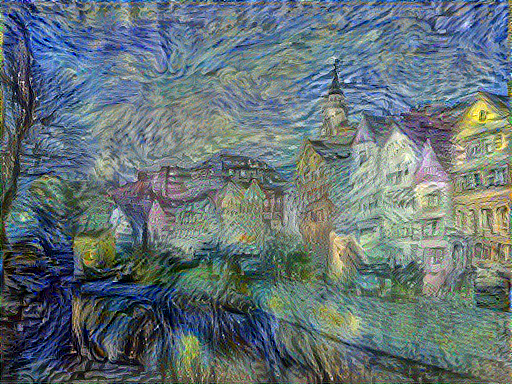

Iteration : 360
Total loss: 1098604.375, Style loss: 442049.375, Content loss: 656555.0


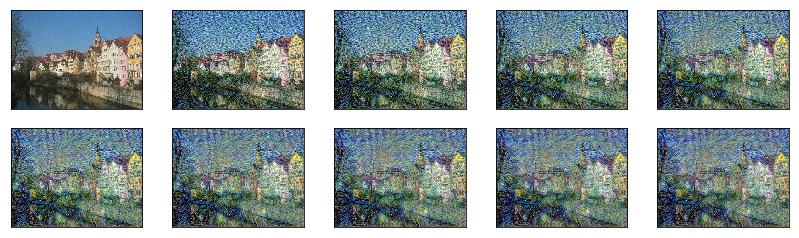

In [17]:
best, best_loss = run_style_transfer(content_path, style_path, num_iters=400)